In [1]:
#import uproot4 as uproot
import uproot
import boost_histogram as bh
import matplotlib.pyplot as plt
import matplotlib as mpl
import mplhep as hep
import awkward1 as ak
import pandas as pd
import numpy as np

In [2]:
import seaborn as sns
def set_sns_color(*args):
    sns.palplot(sns.color_palette(*args))
    sns.set_palette(*args)
    
color_order_bkg = sns.color_palette('Accent', 3)
color_order_bkg.reverse()

In [3]:
use_helvet = True  ## true: use helvetica for plots, make sure the system have the font installed
if use_helvet:
    CMShelvet = hep.style.CMS
    CMShelvet['font.sans-serif'] = ['Helvetica', 'Arial']
    plt.style.use(CMShelvet)
else:
    plt.style.use(hep.style.CMS)

In [4]:
import sys,os
sys.path.append("/cms/user/guojl/ME_test/CMSSW_10_6_26/src/HZZAnalysis/lib")

In [5]:
from utils import *

In [6]:
ori_dir = '/cms/user/guojl/Sample/2L2Q/UL_Legacy/2016/'
samples_inf = {#name path cross Section
                    #'DY_pt50To100':['MC/DYJetsToLL_Pt-50To100_MatchEWPDG20_TuneCP5_13TeV-amcatnloFXFX-pythia8', 363.8142],
                    'DY_pt50To100':['MC/DYJetsToLL_Pt-50To100_MatchEWPDG20_TuneCP5_13TeV-amcatnloFXFX-pythia8', 398.8],
                    #'DY_pt100To250':['MC/DYJetsToLL_Pt-100To250_MatchEWPDG20_TuneCP5_13TeV-amcatnloFXFX-pythia8',84.014804],
                    'DY_pt100To250':['MC/DYJetsToLL_Pt-100To250_MatchEWPDG20_TuneCP5_13TeV-amcatnloFXFX-pythia8',93.61],
                    'DY_pt250To400':['MC/DYJetsToLL_Pt-250To400_MatchEWPDG20_TuneCP5_13TeV-amcatnloFXFX-pythia8',3.67],#3.047],
                    'DY_pt400To650':['MC/DYJetsToLL_Pt-400To650_MatchEWPDG20_TuneCP5_13TeV-amcatnloFXFX-pythia8',0.5],#0.392],
                    'DY_pt650ToInf':['MC/DYJetsToLL_Pt-650ToInf_MatchEWPDG20_TuneCP5_13TeV-amcatnloFXFX-pythia8',0.04704],#0.03636],
                    'TTJets':['MC/TTJets_TuneCP5_13TeV-amcatnloFXFX-pythia8',831.76],
                    'TTTo2L2Nu':['MC/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8',1],
                    'WW_TuneCP5':['MC/WW_TuneCP5_13TeV-pythia8',1],
                    'WWTo2L2Nu':['MC/WWTo2L2Nu_TuneCP5_13TeV-powheg-pythia8',11.09],
                    'WZTo2Q2L':['MC/WZTo2Q2L_mllmin4p0_TuneCP5_13TeV-amcatnloFXFX-pythia8',6.419],
                    'ZZTo2Q2L':['MC/ZZTo2Q2L_mllmin4p0_TuneCP5_13TeV-amcatnloFXFX-pythia8',3.696],
                    'ggH1000':['MC/Signal/skimed/GluGluHToZZTo2L2Q_M1000_TuneCP5_13TeV_powheg2_JHUGenV7011_pythia8__asymptotic_v17-v2_0.root',5.07],
                    'VBF1500':['MC/Signal/skimed/VBF_HToZZTo2L2Q_M1500_TuneCP5_13TeV_powheg2_JHUGenV7011_pythia8__asymptotic_v13-v1_0.root',0.77],
                    'test':'MC/test',
                    'Data':['Data/skimed/Data2016UL_noDuplicates.root',1],
                    }

Samples_lists = ['DY_pt50To100','DY_pt100To250','DY_pt250To400','DY_pt400To650','DY_pt650ToInf',
              'TTJets',
              'WZTo2Q2L',
              'ZZTo2Q2L',
              'WWTo2L2Nu',
              'Data']

#signal_lists = [ 'ggH1000','VBF1500']
signal_lists = [ 'ggH1000']

lumi = {2016: 16.81, 2017: 41.53, 2018: 59.74}
year=2016

bininfo = {'mass2l':[24,60,120,"M(ll)"],
              'pt2l':[70,100,800,"Pt(ll)"],
              #'massmerged':[28,40,180,"M(J)"],
              'massmerged':[40,0,200,"M(J)"],
              'ptmerged':[60,200,800,"Pt(J)"],
              'mass2l2jet':[28,40,180,"M(2l2q)"], 
              'pt2jet':[70,100,800,"Pt(jj)"],
              'mass2jet':[28,40,180,"M(jj)"],
              'particleNetZvsQCD':[20,0,1,"particleNetZvsQCD"],
              'KD_jjVBF':[20,0,1,"VBF(score)"]}

cats = ['isEE','isMuMu']

In [7]:
#var to read
var_read_lists = ['pt2l','mass2l','EventWeight','foundZ1LCandidate','foundTTCRCandidate','foundZ2JCandidate','foundZ2MergedCandidata','foundTTCRCandidate','passedfullmerged','passedfullresolved','particleNetZvsQCD','passedNassociated','isEE','isMuMu',
                        'massmerged','ptmerged',
                        'pt2jet','mass2jet',
                        'mass2l2jet', 'mass2lj',
                        'KD_jjVBF',
                         'isbjet','iscjet','islightjet']

In [8]:
#extract branch for each sample
bkg_array = {}
data_array = None
signal_array = {}
sumWeight = {}

for sample in Samples_lists:
    print(f"This is {sample}")
    if sample!='Data':
        indir = ori_dir+samples_inf[sample][0]+'/skimed'
        files = find_this_rootfiles(indir)
        sumWeight[sample] = 0
            
        for file in files:
            with uproot.open(f'{indir}/{file}') as f:
                this_sumWeight_h = f['sumWeights'].to_boost()
                this_sumWeight = this_sumWeight_h.sum()
                #print(f'this sum weight = {this_sumWeight}')
                sumWeight[sample] += this_sumWeight
                    
        bkg_array[sample] = uproot.lazy([f"{indir}/*.root:passedEvents"],filter_name=var_read_lists)
        
    else:
        data_path = ori_dir+samples_inf['Data'][0]
        data_array = uproot.lazy([f"{data_path}:passedEvents"],filter_name=var_read_lists)

for sample in signal_lists:
    print(f"This is {sample}")
    signal_path = ori_dir+samples_inf[sample][0]
    
    sumWeight[sample] = 0
    with uproot.open(signal_path) as f:
        this_sumWeight_h = f['sumWeights'].to_boost()
        this_sumWeight = this_sumWeight_h.sum()
        sumWeight[sample] += this_sumWeight
        
        signal_array[sample] = f['passedEvents'].arrays(filter_name=var_read_lists,library="ak")

This is DY_pt50To100
This is DY_pt100To250
This is DY_pt250To400
This is DY_pt400To650
This is DY_pt650ToInf
This is TTJets
This is WZTo2Q2L
This is ZZTo2Q2L
This is WWTo2L2Nu
This is Data
This is ggH1000


In [9]:
def make_cut(array,cat): 
    if cat=='DY':
        selection = '((massmerged<70) | (massmerged>135)) & (particleNetZvsQCD>0.9) & (foundZ1LCandidate==True) & (foundZ2MergedCandidata==True)'
        #cut_array = array['foundZ1LCandidate'] & array['foundZ2MergedCandidata'] & ((array['massmerged']<70) | (array['massmerged']>105) & (array['particleNetZvsQCD']>0.9)) #merged
    elif cat=='TT':
        selection = '((massmerged<70) | (massmerged>135)) & (particleNetZvsQCD>0.9) & (foundTTCRCandidate==True) & (foundZ2MergedCandidata==True)'
        #cut_array = array['foundTTCRCandidate'] & array['foundZ2MergedCandidata'] & ((array['massmerged']<70) | (array['massmerged']>105) & (array['particleNetZvsQCD']>0.9)) #merged
    else:
        print("[ERROR] only DY and TT are available")
        sys.exit()
    
    cut_array = ak.numexpr.evaluate(selection,array)
        
    #cut_array = array[cat] & array['foundZ2JCandidate'] & ((array['mass2jet']<70) | (array['mass2jet']>105)) &array['passedNassociated']#resovled
    #cut_array = array[cat] #leptonic Z
    return cut_array

In [10]:
import yaml

In [11]:
sf_particleNet_signal = {}
with open('/cms/user/guojl/ME_test/CMSSW_10_6_26/src/HZZAnalysis/cards/NetSF_signal_2016Legacy.yml') as f:
    sf_particleNet_signal = yaml.safe_load(f)

In [12]:
def GetParticleNetSignalSF(array,tagger):
    if tagger=='ZvsQCD':
        tag = 'particleNetZvsQCD'
    elif tagger=='btag':
        tag = 'particleNetZbbvslight'
    else:
        print("[ERROR] Please enter correctly tagger(only ZvQCD and btag are available )")
        sys.exit()
        
    sf_arr = ak.zeros_like(array['particleNetZvsQCD'])
    sf_arr = ak.to_numpy(sf_arr)
    
    wsp = {"LP":[0.90,0.94],'MP':[0.94,0.98],'HP':[0.98,1.0]}
    flavors = {'bhadron':'isbjet','chadron':'iscjet','lighthadron':'islightjet'}
    pt_ranges = {'200To400':[200,400],'400To600':[400,600],'600ToInf':[600,9999999]} 
    
    for pur in wsp.keys():
        for flavor in flavors.keys():
            for pt_range in pt_ranges.keys():
                cut = "({}>{}) & ({}<={}) & (ptmerged>={}) & (ptmerged<{}) & ({}==True)".format(tag,wsp[pur][0],tag,wsp[pur][1],pt_ranges[pt_range][0],pt_ranges[pt_range][1],flavors[flavor])
                cut_arr = ak.numexpr.evaluate(cut,array)
                sf_arr[cut_arr] = float(sf_particleNet_signal[tagger][flavor][pur][pt_range])
    sf_arr = ak.from_numpy(sf_arr)
    print("This sf_array = ",sf_arr)
    return sf_arr

In [13]:
#apply Z+jet and TT CR cut for each sample
CR_lists = ["DY",'TT']
bkg_array_cut = {}; data_array_cut = {}; signal_array_cut = {}
for CR_list in CR_lists:
    bkg_array_cut[CR_list] = {}; data_array_cut[CR_list] = None;signal_array_cut[CR_list] = {}
    for sample in Samples_lists:
        print(f"This is {sample} in {CR_list}")
        if sample!='Data':
            temp_array = bkg_array[sample]
            cut_array = make_cut(temp_array,CR_list)
            bkg_array_cut[CR_list][sample] = temp_array[cut_array]
        else:
            temp_array = data_array
            cut_array = make_cut(temp_array,CR_list)
            data_array_cut[CR_list] = temp_array[cut_array]
            
    for sample in signal_lists:
        temp_array = signal_array[sample]
        cut_array = make_cut(temp_array,CR_list)
        signal_array_cut[CR_list][sample] = temp_array[cut_array]

This is DY_pt50To100 in DY
This is DY_pt100To250 in DY
This is DY_pt250To400 in DY
This is DY_pt400To650 in DY
This is DY_pt650ToInf in DY
This is TTJets in DY
This is WZTo2Q2L in DY
This is ZZTo2Q2L in DY
This is WWTo2L2Nu in DY
This is Data in DY
This is DY_pt50To100 in TT
This is DY_pt100To250 in TT
This is DY_pt250To400 in TT
This is DY_pt400To650 in TT
This is DY_pt650ToInf in TT
This is TTJets in TT
This is WZTo2Q2L in TT
This is ZZTo2Q2L in TT
This is WWTo2L2Nu in TT
This is Data in TT


This is DY_pt50To100 in DY
This is DY_pt100To250 in DY
This is DY_pt250To400 in DY
This is DY_pt400To650 in DY
This is DY_pt650ToInf in DY
This is TTJets in DY
This is WZTo2Q2L in DY
This sf_array =  [0.881, 0.881, 0.975, 1.08, 0.881, 0.842, ... 0.745, 1.21, 0.887, 0.975, 0.881]
This is ZZTo2Q2L in DY
This sf_array =  [0.89, 1.04, 0.842, 0.842, 0.918, 0.756, ... 0.985, 0.756, 0.89, 0.985, 0.918, 1.07]
This is WWTo2L2Nu in DY
This is Data in DY
data weight  = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ... 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
This is DY_pt50To100 in TT
This is DY_pt100To250 in TT
This is DY_pt250To400 in TT
This is DY_pt400To650 in TT
This is DY_pt650ToInf in TT
This is TTJets in TT
This is WZTo2Q2L in TT
This sf_array =  [1.08, 0.842, 0.985, 0.985, 1.04, 0.842, ... 0.842, 0.881, 0.985, 0.881, 0.881]
This is ZZTo2Q2L in TT
This sf_array =  [0.89, 1.04, 0.881, 0.89, 0.842, 0.881, 0.999, 0.89]
This is WWTo2L2Nu in TT
This is Data in TT
data weight  = [1, 1, 1, 1, 1, 1, 1

/tmp/ipykernel_14318/2072157223.py:105: RuntimeWarning: invalid value encountered in true_divide
  ratio=np.nan_to_num((data/bkg_tot),nan=-1)
/tmp/ipykernel_14318/2072157223.py:106: RuntimeWarning: invalid value encountered in true_divide
  ratio_err = np.nan_to_num((data_err/bkg_tot),nan=-1)
/tmp/ipykernel_14318/2072157223.py:110: RuntimeWarning: invalid value encountered in true_divide
  ratio_unc_low = np.nan_to_num(((bkg_tot-bkg_err)/bkg_tot),nan=-1)
/tmp/ipykernel_14318/2072157223.py:111: RuntimeWarning: invalid value encountered in true_divide
  ratio_unc_up = np.nan_to_num(((bkg_tot+bkg_err)/bkg_tot),nan=-1)


[INFO] it is TT plot


/tmp/ipykernel_14318/2072157223.py:105: RuntimeWarning: invalid value encountered in true_divide
  ratio=np.nan_to_num((data/bkg_tot),nan=-1)
/tmp/ipykernel_14318/2072157223.py:106: RuntimeWarning: invalid value encountered in true_divide
  ratio_err = np.nan_to_num((data_err/bkg_tot),nan=-1)
/tmp/ipykernel_14318/2072157223.py:110: RuntimeWarning: invalid value encountered in true_divide
  ratio_unc_low = np.nan_to_num(((bkg_tot-bkg_err)/bkg_tot),nan=-1)
/tmp/ipykernel_14318/2072157223.py:111: RuntimeWarning: invalid value encountered in true_divide
  ratio_unc_up = np.nan_to_num(((bkg_tot+bkg_err)/bkg_tot),nan=-1)


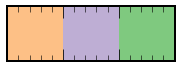

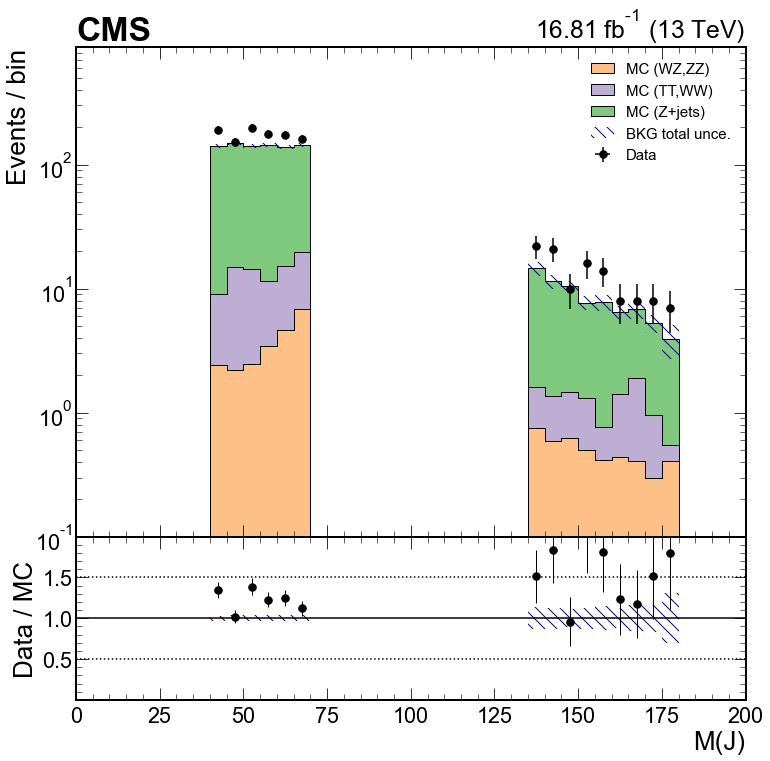

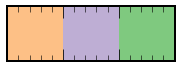

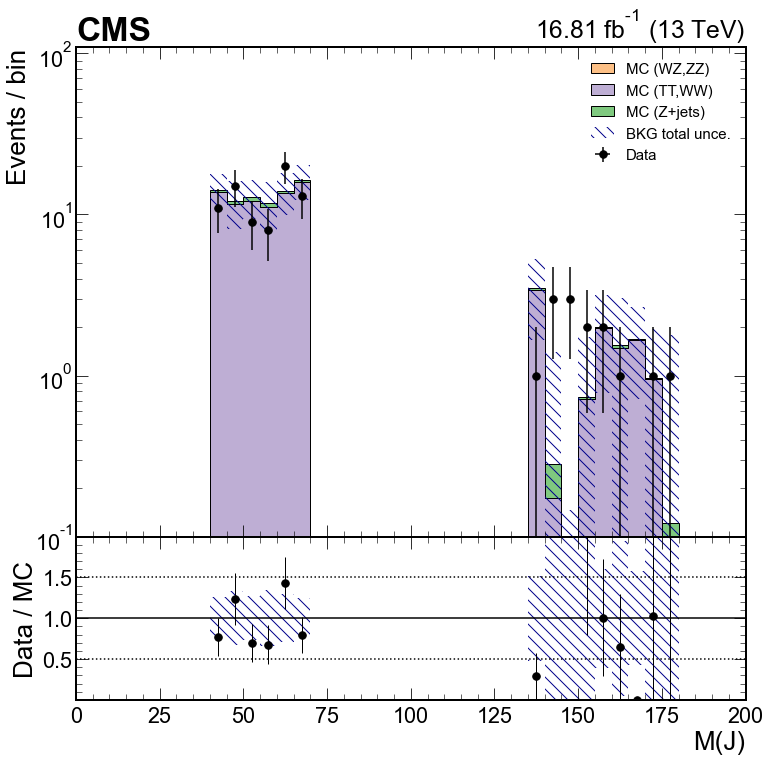

In [14]:
#fill histo 
var = 'massmerged'
nbins, xmin, xmax = bininfo[var][0], bininfo[var][1], bininfo[var][2]
edge = np.linspace(xmin, xmax, nbins+1)
if var.find('pt')!=-1 or var.find('massmerged')!=-1 or var.find('mass2jet')!=-1:
    islogY = True
else:
    islogY = True

bkg_hists = {}; Data_hist = {}; signal_hists={}
for cat in CR_lists:
    bkg_hists[cat] = [None,None,None]; Data_hist[cat] = None ;signal_hists[cat] = []
    for sample in Samples_lists:
        print(f"This is {sample} in {cat}")
        if sample!='Data':
            temp_array = bkg_array_cut[cat][sample]
            weights = (temp_array['EventWeight']*lumi[2016]*1000*samples_inf[sample][1])/sumWeight[sample]
            #ZZ and WZ need NET sf which is the same as signal
            if sample == 'ZZTo2Q2L' or sample =='WZTo2Q2L':
                sf_Net = GetParticleNetSignalSF(temp_array,'ZvsQCD')
                weights = weights*sf_Net
        
            temp_hist = get_hist(temp_array[var],weights,nbins,xmin,xmax)
            
            if sample.find('DY')!=-1:
                if (bkg_hists[cat])[2]==None:
                    (bkg_hists[cat])[2] = temp_hist
                else:
                    (bkg_hists[cat])[2]+=temp_hist
            if sample.find('TTJets')!=-1 or sample.find('WWTo2L2Nu')!=-1:
                if (bkg_hists[cat])[1]==None:
                    (bkg_hists[cat])[1] = temp_hist
                else:
                    (bkg_hists[cat])[1]+=temp_hist
            if sample.find('WZTo2Q2L')!=-1 or sample.find('ZZTo2Q2L')!=-1:
                if (bkg_hists[cat])[0]==None:
                    (bkg_hists[cat])[0] = temp_hist
                else:
                    (bkg_hists[cat])[0]+=temp_hist
        else:
            temp_array = data_array_cut[cat]
            weights = np.ones_like(temp_array['EventWeight'])
            print(f'data weight  = {weights}')
            Data_hist[cat] = get_hist(temp_array[var],weights,nbins,xmin,xmax)

    for sample in signal_lists:
        temp_array = signal_array_cut[cat][sample]
        weights = (temp_array['EventWeight']*lumi[2016]*samples_inf[sample][1]*1000)/sumWeight[sample] #scale 100
        temp_hist = get_hist(temp_array[var],weights,nbins,xmin,xmax)
        signal_hists[cat].append(temp_hist)

print("Fill done")

#draw var
for cat in CR_lists:
    print(f"[INFO] it is {cat} plot")
    plot_unce = True
    set_sns_color(color_order_bkg)
    f = plt.figure(figsize=(12,12))
    gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[3, 1], hspace=0)
    ##================================ Upper histogram panel=========================================
    ax = f.add_subplot(gs[0])
    hep.cms.label(data=True, year=year, ax=ax, rlabel=r'%s $fb^{-1}$ (13 TeV)'%lumi[year], fontname='sans-serif')
    ax.set_xlim(xmin, xmax); ax.set_xticklabels([]); ax.set_ylabel('Events / bin', ha='right', y=1.0)
    
    ##BACKGRUND
    #hep.histplot(bkg_hists[cat],label=[f'MC ({var})' for var in ['WZ,ZZ','TT,WW','Z+jets']],histtype='fill', edgecolor='k', linewidth=1, stack=True) ## draw MC
    plot_hist(bkg_hists[cat],label=[f'MC ({var})' for var in ['WZ,ZZ','TT,WW','Z+jets']],histtype='fill', edgecolor='k', linewidth=1, stack=True) ## draw MC
    bkg_hist = bkg_hists[cat][0]+bkg_hists[cat][1]+bkg_hists[cat][2]
    bkg_tot = bkg_hist.values()
    bkg_err = get_err(bkg_hist)
    #bkg_err = np.sqrt(bkg_hist.view(flow=False).variance)

    if plot_unce:
        #ax.fill_between(edge, (bkg_tot-bkg_err).tolist()+[0], (bkg_tot+bkg_err).tolist()+[0], label='BKG total unce.', step='post', hatch='\\\\', edgecolor='dimgrey', facecolor='none', linewidth=0) ## draw bkg unce. 
        ax.fill_between(edge, (bkg_tot-bkg_err).tolist()+[0], (bkg_tot+bkg_err).tolist()+[0], label='BKG total unce.', step='post', hatch='\\\\', edgecolor='darkblue', facecolor='none', linewidth=0) ## draw bkg unce.
    ax.set_xlim(xmin, xmax); ax.set_xticklabels([]);
    ax.set_ylabel('Events / bin', ha='right', y=1.0);
    
    ##SIGNAL
    #colors = ['blue', 'red']
    #plot_hist(signal_hists[cat],label=[ var for var in ['ggH(m1000)','VBF(m1500)']],linestyle=[style for style in [':','--']], color=[color for color in colors])
    #plot_hist(signal_hists[cat],'ggH(m1000)',linestyle=[style for style in [':','--']], color=[color for color in colors])


    ##DATA
    data_err = get_err(Data_hist[cat])
    data = Data_hist[cat].values()
    #hep.histplot(Data_hist[cat], yerr=data_err,label='Data', histtype='errorbar', color='k', markersize=15, elinewidth=1.5) ## draw data
    plot_hist(Data_hist[cat],label='Data', histtype='errorbar', color='k', markersize=15, elinewidth=1.5) ## draw data
    if islogY:
        ax.set(yscale = "log")
        ax.set_ylim(1e-1, 3*ax.get_ylim()[1])
    else:
        ax.set_ylim(0, ax.get_ylim()[1])
        ax.set_ylim(0, 1.5*max(data))
    hep.plot.yscale_legend
    ax.legend(fontsize=15)

    ##==========================================Ratio panel========================
    ax1 = f.add_subplot(gs[1]); ax1.set_xlim(xmin, xmax); ax1.set_ylim(0.001, 1.999)
    ax1.set_xlabel(bininfo[var][3], ha='right', x=1.0); ax1.set_ylabel('Data / MC', ha='center')
    ax1.plot([xmin,xmax], [1,1], 'k'); ax1.plot([xmin,xmax], [0.5,0.5], 'k:'); ax1.plot([xmin,xmax], [1.5,1.5], 'k:')
    
    ratio=np.nan_to_num((data/bkg_tot),nan=-1)
    ratio_err = np.nan_to_num((data_err/bkg_tot),nan=-1)
    hep.histplot(ratio, yerr = ratio_err,bins=edge, histtype='errorbar', color='k', markersize=15, elinewidth=1)
    #hep.histplot(data/bkg_tot, yerr = data_err/bkg_err,bins=edge, histtype='errorbar', color='k', markersize=15, elinewidth=1)
    if plot_unce:
        ratio_unc_low = np.nan_to_num(((bkg_tot-bkg_err)/bkg_tot),nan=-1)
        ratio_unc_up = np.nan_to_num(((bkg_tot+bkg_err)/bkg_tot),nan=-1)
        ax1.fill_between(edge, ratio_unc_low.tolist()+[0],ratio_unc_up.tolist()+[0], step='post', hatch='\\\\', edgecolor='darkblue', facecolor='none', linewidth=0) ## draw bkg unce.
        #ax1.fill_between(edge, ((bkg_tot-bkg_err)/bkg_tot).tolist()+[0], ((bkg_tot+bkg_err)/bkg_tot).tolist()+[0], step='post', hatch='\\\\', edgecolor='darkblue', facecolor='none', linewidth=0) ## draw bkg unce.

In [15]:
###store histo to a root file 
outCRfilepath = '/cms/user/guojl/ME_test/CMSSW_10_6_26/src/HZZAnalysis/NetMCCalibration/fileCR'
outfile = uproot.recreate(f"{outCRfilepath}/CR_NET090.root")
for cat in CR_lists:
    outfile[f'CR_{cat}/data_obs'] = Data_hist[cat]
    
    outfile[f'CR_{cat}/DY'] = bkg_hists[cat][2]
    outfile[f'CR_{cat}/TTjets'] = bkg_hists[cat][1]
    outfile[f'CR_{cat}/ZV'] = bkg_hists[cat][0]
    
    outfile[f'CR_{cat}/ggh'] = signal_hists[cat][0]    

In [1]:
signal_hists['DY'].view(flow=False).value

NameError: name 'signal_hists' is not defined

AttributeError: 'WritableDirectory' object has no attribute 'key'